# Nested cross-validation

Take a subset of observables and frames as a test set and "train" the remaining set (namely, determine the optimal hyperparameters, as described in the previous notebooks, and then minimize the loss function at the optimal hyperparameters) - external splitting. Then, compute the $\chi^2$ on the test observables at the optimal solution found by `MDRefinement` on the external training set.

We remind you to have a look at our paper https://arxiv.org/pdf/2411.07798 and at the documentation https://www.bussilab.org/doc-MDRefine/MDRefine/index.html.

Required assistance may be opened at https://github.com/bussilab/MDRefine/issues.

In [3]:
import sys, time, datetime
import numpy as np
# import pandas
# import matplotlib.pyplot as plt
import jax.numpy as jnp
import pandas

In [4]:
# import from parent directory
import sys
sys.path.insert(0, '../')

import MDRefine

print("I will use the MDRefine version installed at", MDRefine.__file__)

from MDRefine import load_data, split_dataset, MDRefinement, compute_chi2_test

I will use the MDRefine version installed at ../MDRefine/__init__.py


### python code used also in HPC

In [2]:
# %% input values from bash shell

stride = 1000

# inverse starting hyperparameters, determining the refinement
# 0 for no refinement (infinite hyperpars), 1 otherwise (for example)
inv_starting_alpha = 1
inv_starting_beta = 1
inv_starting_gamma = 0

test_seed = 1  # -1 for no test set

In [3]:
system_names = ['AAAA', 'CAAU']#, 'CCCC', 'GACC', 'UUUU', 'UCAAUC']
random_states = [1,2]#[1,2,3,4,5]

In [4]:
results_folder_name = '6_Result'
id_code = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')
# the folder with output results is: results_folder_name + '_' + id_code

# %%
def forward_model_fun(fm_coeffs, forward_qs, selected_obs = None):

    # 1. compute the cosine (which is the quantity you need in the forward model;
    # you could do this just once before loading data)
    forward_qs_cos = {}

    for type_name in forward_qs.keys():
        forward_qs_cos[type_name] = np.cos(forward_qs[type_name])

    # if you have selected_obs, compute only the corresponding observables
    if selected_obs is not None:
        for type_name in forward_qs.keys():
            forward_qs_cos[type_name] = forward_qs_cos[type_name][:,selected_obs[type_name+'_3J']]

    # 2. compute observables (forward_qs_out) through forward model
    forward_qs_out = {
        'backbone1_gamma_3J': fm_coeffs[0]*forward_qs_cos['backbone1_gamma']**2 + fm_coeffs[1]*forward_qs_cos['backbone1_gamma'] + fm_coeffs[2],
        'backbone2_beta_epsilon_3J': fm_coeffs[3]*forward_qs_cos['backbone2_beta_epsilon']**2 + fm_coeffs[4]*forward_qs_cos['backbone2_beta_epsilon'] + fm_coeffs[5],
        'sugar_3J': fm_coeffs[6]*forward_qs_cos['sugar']**2 + fm_coeffs[7]*forward_qs_cos['sugar'] + fm_coeffs[8]}

    return forward_qs_out

'''
system_name/ff_terms.npy have columns:
sinalpha[0],sinalpha[1],sinalpha[2],sinzeta[0],sinzeta[1],sinzeta[2],cosalpha[0],cosalpha[1],cosalpha[2],coszeta[0],coszeta[1],coszeta[2]
(n. of angles up to n. of residues -1, namely 3 for tetramers and 5 for hexamers)
'''
def ff_correction_tetramers(pars, f):
    # sin alpha, cos alpha, sin zeta, cos zeta:
    # out = jnp.matmul(pars, (f[:,[0,6,3,9]]+f[:,[1,7,4,10]]+f[:,[2,8,5,11]]).T)

    # sin alpha, cos alpha
    out = jnp.matmul(pars, (f[:,[0,6]]+f[:,[1,7]]+f[:,[2,8]]).T)
    
    return out

def ff_correction_hexamers(pars, f):
    out = jnp.matmul(pars, (f[:,[0,10]]+f[:,[1,11]]+f[:,[2,12]]+f[:,[3,13]]+f[:,[4,14]]).T)
    return out

infos = {}

infos['global'] = {
    'path_directory': 'DATA',
    'system_names': system_names,
    'g_exp': ['backbone1_gamma_3J', 'backbone2_beta_epsilon_3J', 'sugar_3J', 'NOEs', ('uNOEs','<')],
    'obs' : ['NOEs', 'uNOEs'],
    'forward_qs':  ['backbone1_gamma', 'backbone2_beta_epsilon', 'sugar'],
    'temperature': 1,  # namely, energies are in unit of k_B T (default value)
    'forward_coeffs': 'original_fm_coeffs',
    'forward_model': forward_model_fun,
    'ff_correction': ff_correction_tetramers,
    'names_ff_pars': ['sin alpha', 'cos alpha']}  # , 'sin zeta', 'cos zeta']}

infos['UCAAUC'] = {'ff_correction': ff_correction_hexamers}

# %%
def forward_model_regularization(coeffs,coeffs_0):
    regularization = (
    3/8*(coeffs[0]-coeffs_0['A_gamma'])**2+1/2*(coeffs[1]-coeffs_0['B_gamma'])**2+(coeffs[2]-coeffs_0['C_gamma'])**2+(coeffs[0]-coeffs_0['A_gamma'])*(coeffs[2]-coeffs_0['C_gamma'])+
    3/8*(coeffs[3]-coeffs_0['A_beta'])**2+1/2*(coeffs[4]-coeffs_0['B_beta'])**2+(coeffs[5]-coeffs_0['C_beta'])**2+(coeffs[3]-coeffs_0['A_beta'])*(coeffs[5]-coeffs_0['C_beta'])+
    3/8*(coeffs[6]-coeffs_0['A_sugar'])**2+1/2*(coeffs[7]-coeffs_0['B_sugar'])**2+(coeffs[8]-coeffs_0['C_sugar'])**2+(coeffs[6]-coeffs_0['A_sugar'])*(coeffs[8]-coeffs_0['C_sugar']))

    return regularization

regularization = {'force_field_reg': 'KL divergence', 'forward_model_reg': forward_model_regularization}

#%% 2. split dataset into training (used by MDRefinement and/or minimizer) and test

time1 = time.time()

data = load_data(infos, stride=stride)

loading data from directory...
loading  AAAA
loading  CAAU
done


In [5]:
if not(test_seed == -1): 
    data_training, data_test, test_obs, test_frames = split_dataset(data, frames_fraction=0.1, obs_fraction=0.1, random_state=test_seed)
else:
    data_training = data

# print('test obs: ', test_obs)

# mini = hyper_minimizer(data_training, regularization=regularization, starting_alpha=1e-1, starting_gamma=1e-1, random_states=[1], which_set='training')

def inverse(inv_hyperpar):
    if inv_hyperpar == 0:
        hyperpar = np.inf
    else:
        hyperpar = 1/inv_hyperpar
    return hyperpar

starting_alpha = inverse(inv_starting_alpha)
starting_beta = inverse(inv_starting_beta)
starting_gamma = inverse(inv_starting_gamma)



Input random_state employed both for observables and frames


In [34]:
Result = MDRefinement(data_training, regularization=regularization, stride=stride, starting_alpha=starting_alpha,
    starting_beta=starting_beta, starting_gamma=starting_gamma, random_states=random_states, which_set='validation',
    results_folder_name=results_folder_name, id_code=id_code, n_parallel_jobs=4)

References for MDRefine package:
I. Gilardoni, V. Piomponi, T. Fröhlking, and G. Bussi, “MDRefine: a Python package for refining Molecular Dynamics trajectories with experimental data”, arxiv (2024)

References for Ensemble Refinement:
J. W. Pitera and J. D. Chodera, “On the use of experimental observations to bias simulated ensembles”, J. Chem. Theory Comp. 8, 3445–3451 (2012).

G. Hummer and J. Köfinger, “Bayesian ensemble refinement by replica simulations and reweighting”, J. Chem. Phys. 143, 243150 (2015).

A. Cesari, A. Gil-Ley, and G. Bussi, “Combining simulations and solution experiments as a paradigm for RNA force field refinement”, J. Chem. Theory Comp. 12, 6192–6200 (2016).

A. Cesari, S. Reißer, and G. Bussi, “Using the maximum entropy principle to combine simulations and solution experiments”, Computation 6, 15 (2018).

J. Köfinger, L. S. Stelzl, K. Reuter, C. Allande, K. Reichel, and G. Hummer, “Efficient ensemble refinement by reweighting”, J. Chem. Theory Comput. 15, 339

In [6]:
if not (test_seed == -1):
    if np.isinf(starting_beta): pars_ff = None
    else: pars_ff = Result.pars[:2]

    if np.isinf(starting_gamma): pars_fm = None
    else: pars_fm = Result.pars[-9:]

    if hasattr(Result, 'min_lambdas'): lambdas = Result.min_lambdas
    else: lambdas = None

NameError: name 'Result' is not defined

In [36]:
if not (test_seed == -1):
    ref_test_chi2 = compute_chi2_test(data_test, regularization)
    test_chi2 = compute_chi2_test(data_test, regularization, pars_ff, pars_fm, lambdas)

all the hyperparameters are infinite


In [22]:
from MDRefine.MDRefine import compute_hypergradient

def compute_chi2_test(data_test, regularization, pars_ff : np.ndarray = None, pars_fm : np.ndarray = None, lambdas : dict = None, which_set : str = 'validation'):
    """
    Compute the chi2 on the test set, after the optimal solution has been found.
    
    -----------
    Parameters:
        data_test : object
            Object for the test dataset, as returned by `split_dataset`.
        pars_ff : np.ndarray
            Numpy 1d array for the force-field correction parameters.
        pars_fm : np.ndarray
            Numpy 1d array for the forward model parameters.
        lambdas : dict
            Dictionary for the lambda coefficients (of ensemble refinement).
        which_set : str
            String variable, if `'validation'` compute the chi2 on validation observables and validation frames.
    
    ----------
    Return:
        red_chi2 : float
            Reduced chi2 (chi2 / n. of observables) 
    """
    assert which_set == 'validation' or which_set == 'valid_obs', 'you are not computing the chi2 on test observables'

    if lambdas is None: log10_alpha = np.inf
    else: log10_alpha = 0

    if pars_ff is None:
        log10_beta = np.inf
        pars = np.array([])
    else:
        log10_beta = 0
        pars = pars_ff

    if pars_fm is None: log10_gamma = np.inf
    else:
        log10_gamma = 0
        pars = np.concatenate((pars, pars_fm))

    # # fake regularization, since we are interested in the chi2 only
    # forward_model_regularization = lambda x, x0 : (x - x0)**2
    # regularization = {'force_field_reg': 'KL divergence', 'forward_model_reg': forward_model_regularization}

    chi2 = compute_hypergradient(pars, lambdas, log10_alpha, log10_beta, log10_gamma, data_test, regularization,
        which_set, data_test, None)

    if which_set == 'validation' or which_set == 'valid_obs':
        
        n_obs_test = 0
        for s in data_test.mol.keys():
            n_obs_test += np.sum(np.array(list(data_test.mol[s].n_experiments_new.values())))
        
        chi2 = chi2/n_obs_test

    return chi2

In [6]:
starting_beta = np.inf
starting_gamma = 1#np.inf

if np.isinf(starting_beta): pars_ff = None
else: pars_ff = np.zeros(2)

if np.isinf(starting_gamma): pars_fm = None
else: pars_fm = np.zeros(9)

compute_chi2_test(data_test, regularization, pars_ff, pars_fm)

new weights are equal to original weights


DeviceArray(1123.65270202, dtype=float64)

In [19]:
print(pars_ff, pars_fm)

None [0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [20]:
compute_chi2_test(data_test, regularization, pars_ff, pars_fm)

new weights are equal to original weights


DeviceArray(1123.65270202, dtype=float64)

In [8]:
from MDRefine.MDRefine import compute_chi2_test

compute_chi2_test(data_test, regularization, pars_ff, pars_fm)

new weights are equal to original weights


DeviceArray(1123.65270202, dtype=float64)

In [16]:
if pars_ff is None:
    log10_beta = np.inf
    pars = []
else:
    log10_beta = 0
    pars = pars_ff

if pars_fm is None: log10_gamma = np.inf
else:
    log10_gamma = 0
    pars = np.concatenate((pars, pars_fm))

In [37]:
dtime = time.time() - time1

with open(results_folder_name + '_' + id_code + '/out.txt', 'w') as f:
    print('time required: ', dtime, file=f)
    if not (test_seed == -1):
        print('reference test chi2: ', ref_test_chi2, file=f)
        print('test chi2: ', test_chi2, file=f)
    
    if (test_seed == -1): print('whole set', file=f)
    else: print(test_seed, file=f)
    
    print(vars(Result), file=f)

if not (test_seed == -1):
    with open(results_folder_name + '_' + id_code + '/test_obs.txt', 'w') as f:
        print(test_obs, file=f)

In [38]:
dict_chi2 = {}

dict_chi2['time'] = dtime
dict_chi2['test seed'] = test_seed

if not (test_seed == -1):
    dict_chi2['ref. test chi2'] = ref_test_chi2
    dict_chi2['test chi2'] = test_chi2

In [39]:
data_train_inn, data_valid, _, _ = split_dataset(data_training)
# reduced chi2 for reference ensemble at random data_valid
dict_chi2['ref. validation chi2'] = compute_chi2_test(data_valid, regularization)

df = pandas.read_csv('6_Result_2025_03_21_10_44_01/hyper_search', index_col=0)
n_valid_obs = 0.2*data_training.properties.tot_n_experiments(data_training)

dict_chi2['validation chi2'] = df['av_chi2'].iloc[-1]/n_valid_obs

random state:  928
Input random_state employed both for observables and frames
all the hyperparameters are infinite


In [40]:
df = pandas.DataFrame([dict_chi2]).to_csv(results_folder_name + '_' + id_code + '/chi2s')

### plot results

In [ ]:
import matplotlib.pyplot as plt

#### only alpha, beta are finite

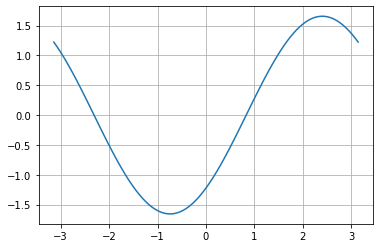

In [41]:
phi = np.linspace(-np.pi, np.pi, 100)

ff = pars_ff[0]*np.sin(phi) + pars_ff[1]*np.cos(phi)

plt.plot(phi, ff)
plt.grid()

#### alpha, beta, gamma finite

In [55]:
pars_ff = [0.47, -0.69]

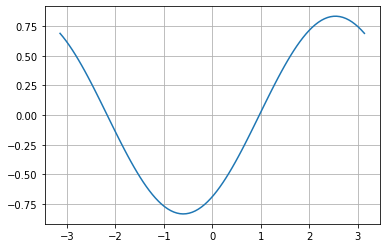

In [56]:
phi = np.linspace(-np.pi, np.pi, 100)

ff = pars_ff[0]*np.sin(phi) + pars_ff[1]*np.cos(phi)

plt.plot(phi, ff)
plt.grid()

In [19]:
def karplus_eqs(abc_vec, label):
    a = abc_vec[0]
    b = abc_vec[1]
    c = abc_vec[2]
    
    phi = np.linspace(-np.pi, np.pi, 100)
    jcoupl = a*np.cos(phi)**2 + b*np.cos(phi) + c
    plt.plot(phi, jcoupl, label=label)
    return jcoupl

In [53]:
pars_fm = [10.004597324896954,-1.8485215697269826,-0.09784818743664454,17.661008908704908,-5.620509738472044,0.3666656352130098,8.313714052123622,-1.747608179308823,0.07022860454362531]


In [57]:
pars_fm = [10.11932004706091,-1.8353743442277473,-0.15889622628224842,18.46473060154171,-5.407652128177933,-0.0010797721325949815,8.302189107903807,-1.8122958419840105,-0.027826707440357056]

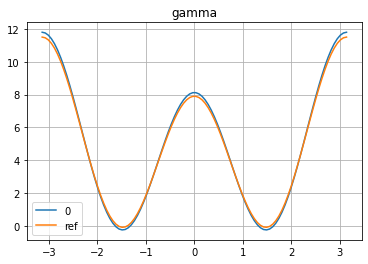

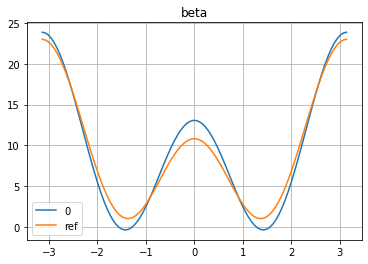

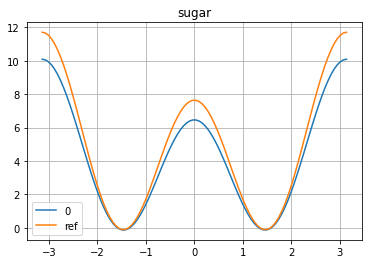

In [58]:
out = karplus_eqs(pars_fm[:3], '0')
out = karplus_eqs([9.7, -1.8, 0.0], 'ref')
plt.title('gamma')
plt.grid()
plt.legend()

plt.figure()
out = karplus_eqs(pars_fm[3:6], '0')
out = karplus_eqs([15.3, -6.1, 1.6], 'ref')
plt.title('beta')
plt.grid()
plt.legend()

plt.figure()
out = karplus_eqs(pars_fm[6:], '0')
out = karplus_eqs([9.67, -2.03, 0.], 'ref')
plt.title('sugar')
plt.legend()
plt.grid()

## Analysis of the results

In [8]:
import os
import matplotlib.pyplot as plt

In [14]:
dir_list = os.listdir('6_Results_cv')

temp = []

for s in dir_list:
    df = pandas.read_csv('6_Results_cv/' + s + '/input', index_col=0)
    df2 = pandas.read_csv('6_Results_cv/' + s + '/result', index_col=0)

    path_chi2 = '6_Results_cv/' + s + '/chi2s'
    if os.path.exists(path_chi2): df3 = pandas.read_csv(path_chi2, index_col=0)
    else: df3 = pandas.DataFrame({'temp': [np.nan]})
    df3.index = df2.index

    df = pandas.concat([df, df2, df3], axis=1)
    df['stride'] = 10**np.int(6 - np.round(np.log10(np.load('6_Results_cv/' + s + '/weights_new_AAAA.npy').shape[0])))
    temp.append(df)

sims = pandas.concat(temp, axis=0, ignore_index=False)
del sims['temp']

sims

,starting_alpha,starting_beta,starting_gamma,random_states,which_set,gtol,ftol,loss,sin alpha,cos alpha,...,chi2_UUUU,chi2_UCAAUC,ER success CCCC,ER success GACC,ER success UUUU,ER success UCAAUC,D_KL_alpha_CCCC,D_KL_alpha_GACC,D_KL_alpha_UUUU,D_KL_alpha_UCAAUC
2025_03_21_10_33_35,inf,1.0,inf,"[1, 2]",validation,0.5,0.05,209.195517,5.239417,-6.040431,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025_03_21_10_44_01,1.0,1.0,inf,"[1, 2]",validation,0.5,0.05,83.743257,1.117302,-1.223146,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025_03_21_11_15_35,1.0,1.0,inf,"[1, 2]",validation,0.5,0.05,83.743257,1.117302,-1.223146,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025_03_21_11_37_39,1.0,1.0,1.0,"[1, 2]",validation,0.5,0.05,185.392692,7.391073,-7.395274,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025_03_21_11_39_13,inf,1.0,1.0,"[1, 2, 3, 4, 5]",validation,0.5,0.05,10398.228797,0.930460,-0.998298,...,461.407009,6786.858717,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025_03_21_11_39_42,1.0,1.0,inf,"[1, 2, 3, 4, 5]",validation,0.5,0.05,1061.865305,0.923510,-1.284774,...,208.823576,738.032314,True,True,True,True,0.008901,0.000236,0.053444,0.390171
2025_03_21_11_40_12,1.0,1.0,1.0,"[1, 2, 3, 4, 5]",validation,0.5,0.05,190.735241,0.535323,-0.747331,...,16.396069,150.319526,True,True,True,True,0.311276,0.178949,0.551581,2.737699
2025_03_21_11_44_50,1.0,1.0,1.0,"[1, 2, 3, 4, 5]",validation,0.5,0.05,156.851505,0.440811,-0.657408,...,13.953523,124.552084,True,True,True,True,0.439747,0.299271,0.585437,3.140799
2025_03_21_11_50_31,inf,1.0,inf,"[1, 2, 3, 4, 5]",validation,0.5,0.05,10423.386511,0.930385,-0.998289,...,481.356602,6794.493495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025_03_21_11_52_42,inf,inf,1.0,"[1, 2, 3, 4, 5]",validation,0.5,0.05,77112.626610,NaN,NaN,...,1312.963776,8755.863653,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
sims.columns

Index(['starting_alpha', 'starting_beta', 'starting_gamma', 'random_states',
       'which_set', 'gtol', 'ftol', 'loss', 'sin alpha', 'cos alpha',
       'success', 'norm gradient', 'time', 'reg_ff_AAAA', 'reg_ff_CAAU',
       'chi2_AAAA', 'chi2_CAAU', 'optimal beta', 'hyper_mini success',
       'stride', 'ER success AAAA', 'ER success CAAU', 'D_KL_alpha_AAAA',
       'D_KL_alpha_CAAU', 'optimal alpha', 'ref. test chi2', 'test chi2',
       'ref. validation chi2', 'validation chi2', 'A_gamma', 'B_gamma',
       'C_gamma', 'A_beta', 'B_beta', 'C_beta', 'A_sugar', 'B_sugar',
       'C_sugar', 'reg_fm', 'optimal gamma', 'reg_ff_CCCC', 'reg_ff_GACC',
       'reg_ff_UUUU', 'reg_ff_UCAAUC', 'chi2_CCCC', 'chi2_GACC', 'chi2_UUUU',
       'chi2_UCAAUC', 'ER success CCCC', 'ER success GACC', 'ER success UUUU',
       'ER success UCAAUC', 'D_KL_alpha_CCCC', 'D_KL_alpha_GACC',
       'D_KL_alpha_UUUU', 'D_KL_alpha_UCAAUC'],
      dtype='object')

In [5]:
sims = sims.loc[sims['random_states'] == '[1, 2, 3, 4, 5]']
sims = sims.loc[sims['which_set'] == 'validation']

cols = ['optimal alpha', 'optimal beta', 'optimal gamma', 'stride', 'gtol', 'ftol', 'sin alpha', 'cos alpha', 'A_gamma', 'B_gamma', 'C_gamma',
    'A_beta', 'B_beta', 'C_beta', 'A_sugar', 'B_sugar', 'C_sugar', 'ref. test chi2', 'test chi2',
    'ref. validation chi2', 'validation chi2']

sims = sims[cols]
sims = sims.loc[~np.isnan(sims['ref. validation chi2'])]

sims

,optimal alpha,optimal beta,optimal gamma,stride,gtol,ftol,sin alpha,cos alpha,A_gamma,B_gamma,...,A_beta,B_beta,C_beta,A_sugar,B_sugar,C_sugar,ref. test chi2,test chi2,ref. validation chi2,validation chi2
2025_03_21_14_08_47,14.033165,1.057878,1.503405,100,0.5,0.05,0.535323,-0.747331,10.004597,-1.848522,...,17.661009,-5.620510,0.366666,8.313714,-1.747608,0.070229,607.291993,23.157215,318.361789,17.805832
2025_03_21_14_56_45,16.398810,NaN,1.797879,10,0.5,0.05,NaN,NaN,9.948150,-1.826796,...,18.216085,-5.409460,0.177930,8.857488,-1.813861,-0.372726,630.907830,0.772700,247.840975,0.662379
2025_03_21_15_23_34,21.869598,NaN,1.039602,10,0.5,0.05,NaN,NaN,10.126666,-1.854575,...,19.008488,-5.247719,-0.263625,8.593576,-1.849794,-0.202082,NaN,NaN,319.102636,0.469472
2025_03_21_16_39_42,83.245302,NaN,1.867555,100,0.5,0.05,NaN,NaN,9.887649,-1.828467,...,18.257766,-5.382665,0.140397,8.353412,-1.799974,-0.033972,NaN,NaN,297.540456,1.016735
2025_03_21_19_05_02,11.508993,1.171600,1.197884,100,0.5,0.05,0.474691,-0.690215,10.119320,-1.835374,...,18.464731,-5.407652,-0.001080,8.302189,-1.812296,-0.027827,NaN,NaN,248.284207,26.658396
2025_03_21_19_43_52,9.631000,0.983900,1.717681,10,0.5,0.05,0.404987,-0.719071,9.986311,-1.850345,...,18.134194,-5.485887,0.189476,8.777295,-1.763384,-0.133016,528.888844,1.746489,267.239712,0.746550
2025_03_21_19_47_23,47.052678,1.394321,1.074077,10,0.5,0.05,0.643925,-1.375943,9.947273,-1.806707,...,18.034856,-5.492220,0.155814,7.657749,-1.708079,0.333364,NaN,NaN,203.733693,1.364102
2025_03_21_20_08_55,9.864360,1.014384,1.495368,10,0.5,0.05,0.463705,-0.915608,9.996553,-1.911938,...,18.274245,-5.485809,0.083908,8.598105,-1.808440,-0.130527,651.011505,57.133748,302.262432,2.916898
2025_03_21_20_14_59,14.033165,1.057878,1.503405,100,0.5,0.05,0.535323,-0.747331,10.004597,-1.848522,...,17.661009,-5.620510,0.366666,8.313714,-1.747608,0.070229,607.291993,23.157215,227.880768,17.805832
2025_03_21_21_10_32,16.109105,0.930309,1.915637,10,0.5,0.05,0.517048,-0.767462,9.905705,-1.812897,...,17.824162,-5.537363,0.335556,8.435193,-1.761742,-0.109274,630.907830,0.772700,208.619716,0.662379


- if someone among `optimal_alpha`, `optimal_beta`, `optimal_gamma` is `NaN`, it means no refinement in that direction
- if `ref. test chi2` is `NaN` (but `ref. validation chi2` is not), it means there is not the (external) test set

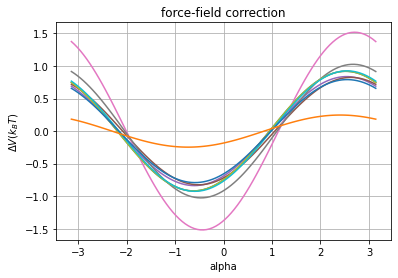

In [9]:
phi = np.linspace(-np.pi, np.pi, 100)

for s in sims.index:
    pars_ff = list(sims.loc[s][['sin alpha', 'cos alpha']])
    ff = pars_ff[0]*np.sin(phi) + pars_ff[1]*np.cos(phi)
    plt.plot(phi, ff)

plt.title('force-field correction')
plt.xlabel('alpha')
plt.ylabel('$\Delta V (k_B T)$')
plt.grid()

In [10]:
def karplus_eqs(abc_vec, label = None):
    a = abc_vec[0]
    b = abc_vec[1]
    c = abc_vec[2]
    
    phi = np.linspace(-np.pi, np.pi, 100)
    jcoupl = a*np.cos(phi)**2 + b*np.cos(phi) + c
    if label is None: plt.plot(phi, jcoupl)
    else: plt.plot(phi, jcoupl, label=label)
    
    return jcoupl

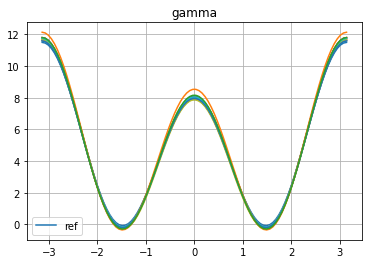

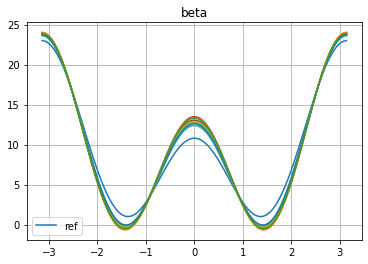

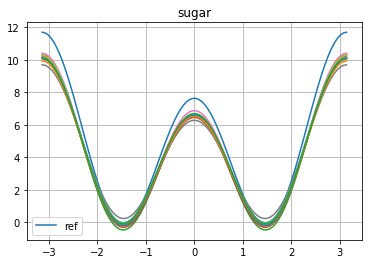

In [11]:
out = karplus_eqs([9.7, -1.8, 0.0], 'ref')
for s in sims.index:
    pars_fm = list(sims.loc[s][['A_gamma', 'B_gamma', 'C_gamma']])
    out = karplus_eqs(pars_fm[:3])

plt.title('gamma')
plt.grid()
plt.legend()

plt.figure()
out = karplus_eqs([15.3, -6.1, 1.6], 'ref')
for s in sims.index:
    pars_fm = list(sims.loc[s][['A_beta', 'B_beta', 'C_beta']])
    out = karplus_eqs(pars_fm[:3])

plt.title('beta')
plt.grid()
plt.legend()

plt.figure()
out = karplus_eqs([9.67, -2.03, 0.], 'ref')
for s in sims.index:
    pars_fm = list(sims.loc[s][['A_sugar', 'B_sugar', 'C_sugar']])
    out = karplus_eqs(pars_fm[:3])

plt.title('sugar')
plt.grid()
plt.legend()

In [12]:
def plot_DataFrame(df, labels=None, xticks_name=None):

        barWidth = 1/(len(df.columns) + 1)

        plt.subplots(figsize=(12, 8)) 

        brs = []
        brs.append(np.arange(len(df.iloc[:, 0])))

        if labels == None: labels = df.columns
        if xticks_name == None: xticks_name = list(df.index)

        plt.bar(brs[-1], df.iloc[:, 0], label=labels[0], width=barWidth)  # edgecolor ='grey', color ='tab:blue')

        for i in range(1, len(df.columns)):
                brs.append([x + barWidth for x in brs[-1]])
                plt.bar(brs[-1], df.iloc[:, i], label=labels[i], width=barWidth)  # edgecolor ='grey', color ='tab:blue')

        plt.xticks([r + barWidth*(len(df.columns) - 1)/2 for r in range(len(df.iloc[:, 0]))], xticks_name)
        # plt.xticks([r + barWidth for r in range(len(df.iloc[:, 0]))], list(df.index))
        # plt.xlabel(list(df.index))

        # plt.xlabel('Branch', fontweight ='bold', fontsize = 15) 
        # plt.ylabel('Students passed', fontweight ='bold', fontsize = 15) 
        # plt.xticks([r + barWidth for r in range(len(df['Aduri'].iloc[:-1]))], names_charges)

        plt.legend()
        plt.gca().xaxis.grid(True)
        # plt.grid()
        # plt.show()

        return

In [105]:
sims.loc[s]['ref. test chi2']

551.1171884966896

In [ ]:
for s in sims.index:
    sims.loc[s]['ref. test chi2']
    chi2 = list(sims.loc[s][['ref. test chi2', 'test chi2', 'ref. validation chi2', 'validation chi2']])
